# TP Coding Convolutional Neural Networks in tensorflow and keras

TP author : Geoffroy Peeters, Alasdair Newson

### Objective:

We want to implement a Convolutional Neural Network (CNN) to do image recognition. For this we will use the well-known CIFAR-10 dataset https://www.cs.toronto.edu/~kriz/cifar.html.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

We will first code the simple ConvNet described below using 
- tensorflow https://www.tensorflow.org

then do the same using
- keras : https://keras.io


The input of the CNN is a set of (32,32,3) image tensors. We apply :

    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we do not apply zero-padding)
    - a ReLu activation function
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we do not apply zero-padding)
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we do not apply zero-padding)
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - We then Flatten the data (reduce them to a vector in order to be able to apply a Fully-Connected layer to it)
    - A softmax activation function which outputs are the $P(y_c | X)$ (multi-class problem)

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE)

# Load packages

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Import data

We first import CIFAR-10 dataset.

In [46]:
from keras.utils.np_utils import to_categorical

from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape)
print(X_test.shape)
print(np.unique(y_train))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
[0 1 2 3 4 5 6 7 8 9]


The CIFAR-10 dataset has 10 classes. These are the following :

In [0]:
cifar_10_list = [ 'airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']

### Display some of the images

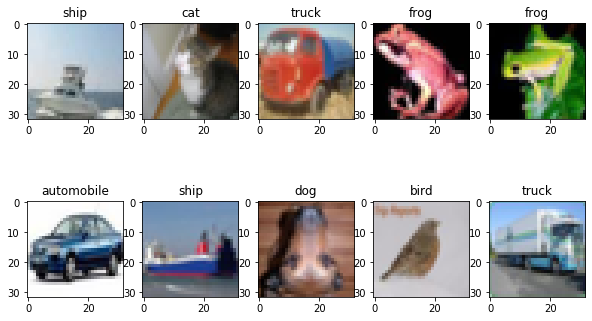

In [48]:
#without plt the images will not remain; it will just print the last one.
plt.figure(figsize=(10, 6))
for idx,i in enumerate(range(100,110)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(X_train[i, :, :, :])
    plt.title(cifar_10_list[int(y_train[i])])

In [49]:
y_train.shape

(50000, 1)

## Format conversion

We now convert the format of the data. In the case of CNNs, and contrary to MLPs, the inputs are not simply vectors of arbitrary size. For example, in the case of images, it is important to distinguish the different dimensions (otherwise the network would not know how to carry out convolutions). Therefore, you need to carry out the following operation :

- reshape the input ```X_train```and ```X_test``` to a set of matrices of size (32,32) and depth 3 (for the 3 R,G,B colors), convert the data to float32 and normalize them in the range [0,1]. The final dimensions of the image data should be : [batch_size, height, width, n_channels]

Furthermore, as in the previous lab work, you must also convert the label vectors to matrices with k columns, where k is the number of classes. This allows us to carry out the cross-entropy for multi-class problems. Therefore :

- convert the output label ```y_train``` and ```y_test``` to one-hot encoding format.

In [50]:
# input image dimensions
img_rows, img_cols, nb_channels = 32, 32, 3
nb_classes = 10
#print("training before", X_train.shape[0])
# In case depth is 1 (black and white pictures) -> reshape to proper format
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, nb_channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, nb_channels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

#it's very important to convert classes to categorical for multiclass classification problems because it allows to use the sofmax
#activation function; the tensorflow example for to_categorical method explain it very well.
#This operation correspond to taking each class and converting it to OHE vector so the dimenssions of Y_train will be 5000(labels of each data point)*10(total number of classes)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('Y_train shape:', Y_train.shape)
print('There is {} train data'.format(X_train.shape[0]))
print('There is {} test data'.format(X_test.shape[0]))
print(img_rows, img_cols, nb_channels)

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
Y_train shape: (50000, 10)
There is 50000 train data
There is 10000 test data
32 32 3


For memory and speed reasons, we are going to reduce the amount of training data :

In [51]:
n_train_samples = 10000
X_train = X_train[0:n_train_samples,:,:,:]
Y_train = Y_train[0:n_train_samples,:]
print(X_train.shape)
print(Y_train.shape)

(10000, 32, 32, 3)
(10000, 10)


# 1. CNN with tensorflow

We are now going to create a CNN with Tensorflow, and train it on the previously loaded CIFAR dataset.
- First define the input and output using ```tf.placeholder```
- Define the weights W1,b1,W2,b2 of the CNN using ```tf.variable``` or ```tf.get_variable```
    - You can initialize them using ```tf.contrib.layers.xavier_initializer```(see https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer)
- Perform the convolution using ```tf.nn.conv2d``` 
- Apply the activation function using ```tf.nn.relu```
- Perform the max pooling using ```tf.nn.max_pool```
- Flatten the output of the convolution using ```tf.contrib.layers.flatten```
- Perform the Fully-Connected part using ```tf.contrib.layers.fully_connected```

Also, note that in Tensorflow, you can carry out the softmax + cross entropy all in one step with the following function :

- ```tf.nn.softmax_cross_entropy_with_logits()```

This has the advantage of being optimised and stabilised by the programmers who wrote Tensorflow, so that you do not have numerical problems.

$\textbf{IMPORTANT NOTE}$ : Please note that this part in Tensorflow is just so that you have had some experience with CNNs in Tensorflow. So do not spend a lot of time trying to get great accuracy results. If you want to do this, do it in the Keras part.

In [0]:
import tensorflow as tf

learning_rate = 0.01
n_epochs = 20
batch_size = 64

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernelSize = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)


# --- Size of the successice layers
n_h_0 = nb_channels
n_h_1 = nb_filters
n_h_2 = nb_filters
n_h_3 = nb_filters


In [53]:
tf.reset_default_graph()

# input tensor are of shape [batch, in_height, in_width, in_channels]  
# filter / kernel tensor are of shape [filter_height, filter_width, in_channels, out_channels]

# --- START CODE HERE

#define the input
filter_dimession = 3
initializer = tf.contrib.layers.xavier_initializer()

#tf.placeholder() i used the declare the input a nd the ouput of the network.
X_input = tf.placeholder(tf.float32,shape = [None,img_rows,img_cols,nb_channels] , name ="input")
Y_output = tf.placeholder(tf.float32,shape = [None,nb_classes],name = "output")


#W1 represent the weights(which are also the filters); the shape should be something like (size1,size2,in_channels,out_channels)
#it's important to notice each filter is associated with one bias!!
W1 = tf.get_variable(initializer=tf.contrib.layers.xavier_initializer() , shape =[filter_dimession,filter_dimession, n_h_0, n_h_1] , name = "weights1" )
b1 = tf.get_variable(initializer=tf.contrib.layers.xavier_initializer(),shape=[32],trainable=True, name='biases1')
#W1 = tf.add(W1,b1)

W2 = tf.get_variable(name = "weights2" ,shape = [filter_dimession,filter_dimession, n_h_1, n_h_2],initializer=tf.contrib.layers.xavier_initializer()  )
b2 = tf.get_variable(initializer=tf.contrib.layers.xavier_initializer(), shape=[32],trainable=True, name='biases2')
#W2 = tf.add(W2,b2)

W3 = tf.get_variable(initializer=tf.contrib.layers.xavier_initializer() , shape = [filter_dimession,filter_dimession, n_h_2, n_h_3], name = "weights3" )
b3 = tf.get_variable(initializer=tf.contrib.layers.xavier_initializer(), shape=[32],trainable=True, name='biases3')
#W3 = tf.add(W3,b3)

#NB: NEVER INITIALIZE WEIGHTS WITH ZEROS, BECAUSE THIS LEAD TO A REALLY BAD ACCURACY!!!!
conv1 = tf.nn.conv2d(input = X_input, filter= W1,strides = [1,1],padding= "SAME",name="conv1")
conv1 = tf.nn.bias_add(conv1,b1)
conv1 = tf.nn.relu(conv1, name = "relu1")

conv2 = tf.nn.conv2d(conv1 , filter = W2 ,strides = [1,1],padding= "SAME",name="conv2")
conv2 = tf.nn.bias_add(conv2,b2)
conv2 = tf.nn.relu(conv2, name = "relu2")

pool1 = tf.nn.max_pool(conv2, ksize=pool_size, strides=pool_size,padding= "SAME")

conv3 = tf.nn.conv2d(pool1, filter = W3,strides = [1,1],padding= "SAME",name="conv3")
conv3 = tf.nn.bias_add(conv3,b3)
conv3 = tf.nn.relu(conv3, name = "relu3")

pool2 = tf.nn.max_pool(conv3, ksize=pool_size, strides=pool_size, padding= "SAME")

flattened_output = tf.contrib.layers.flatten(pool2)

print(flattened_output.shape)
Z4 = tf.contrib.layers.fully_connected(inputs = flattened_output , num_outputs= nb_classes,
                           weights_initializer =tf.contrib.layers.xavier_initializer()
                          ,biases_initializer=tf.zeros_initializer(),activation_fn = None)

print(Z4.shape)
# --- END CODE HERE

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z4, labels = Y_output))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

(?, 2048)
(?, 10)


## Train the model

Cost after epoch 0: 2.062121
Cost after epoch 1: 1.714115
Cost after epoch 2: 1.587963
Cost after epoch 3: 1.525890
Cost after epoch 4: 1.476500
Cost after epoch 5: 1.455305
Cost after epoch 6: 1.451705
Cost after epoch 7: 1.413537
Cost after epoch 8: 1.364494
Cost after epoch 10: 1.321474
Cost after epoch 11: 1.302775
Cost after epoch 12: 1.317452
Cost after epoch 13: 1.277948
Cost after epoch 14: 1.284743
Cost after epoch 15: 1.255873
Cost after epoch 16: 1.271188
Cost after epoch 17: 1.256302
Cost after epoch 18: 1.257341
Cost after epoch 19: 1.237325


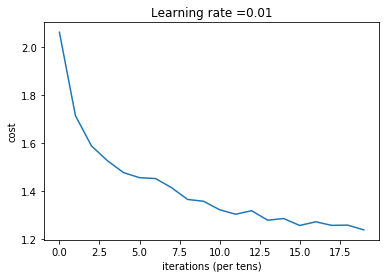

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.5809
Test Accuracy: 0.4859


In [54]:
init = tf.global_variables_initializer()
#np.ceil(x) will return the smalles integer greater than x
n_batches = int(np.ceil(X_train.shape[0] / float(batch_size)))
costs = []
with tf.Session() as sess:
    #this will initialize al the required variblaes declared using the satement tf.varibale()
    sess.run(init)
    
    for epoch in range(n_epochs):
        minibatch_cost = 0.
        for batch_idx in range(n_batches):
            # BEGIN CODE HERE
            #this subdivions of the input is mainly to make the training faster and avoid memory issues!!
            X_batch = X_train[batch_idx*batch_size:batch_idx*batch_size+batch_size,:,:,:]
            y_batch = Y_train[batch_idx*batch_size:batch_idx*batch_size+batch_size,:]
            #temp_cost = cost.eval({X_input: X_batch, Y_output: y_batch})
            opt,temp_cost = sess.run([optimizer,cost], feed_dict= {X_input: X_batch, Y_output: y_batch}) 
            # END CODE HERE
            minibatch_cost += temp_cost / n_batches

        if epoch % 1 == 0:
            print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            
        costs.append(minibatch_cost) 
        
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # Calculate the correct predictions
    predict_op = tf.argmax(Z4, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y_output, 1))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print(accuracy)
    train_accuracy = accuracy.eval({X_input: X_train, Y_output: Y_train})
    test_accuracy = accuracy.eval({X_input: X_test, Y_output: Y_test})
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    


The train accuracy after 20 epochs should be around 0.5. You do not have to push the training further than this, just make sure that the loss decreases and that the accuracy is reasonable. We will now create the same network in Keras.

# 2. CNN with keras

We are now going to create the same network with Keras. As we shall see, the interface is quite simplified in comparison to Tensorflow.

## We first import keras packages

In [11]:
tf.reset_default_graph()
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
print(keras.__version__)

2.2.5


## We define the parameters of the model, and of the training

In [0]:
input_shape = (img_rows, img_cols, nb_channels)

## Creating the CNN model in Keras using the Sequential API

Keras has a simple way of adding layers to create a neural network. First, you can indicate to Keras that the model is 'sequential', that is to say, a straight-forward CNN. For this, you can use the following function :
- ```model = Sequential()```

After this, you can add layers with the function.

- ```model.add()```

You can then use the ```Conv2D```, ```Activation```, ```MaxPooling2D```, ```Flatten``` and ```Dense``` (fully connected) functions to specify different layer types. Note that in the case of this approach, you will have to specify the input image size in the first layer of the network. So, for example, if the first layer is convolutional :

- model = Sequential()
- model.add(Conv2D(nb_filters, kernel_size, input_shape=input_shape, name='Conv1'))


## Creating the CNN model in Keras using the standard API

Otherwise, another approach to creating the model is to explicitly create the input variable, and just cascade the different functions, as in Tensorflow. So, for the same example, we would have :

- input = Input(shape=(img_rows,img_cols,nb_channels))
- output = Conv2D(input_shape=self.img_shape,filters=nb_filters,kernel_size=kernel_size)(input)
- model = Model(input, output)

Create your CNN now with the network parameters specified above.

In [0]:
# --- START CODE HERE
nb_classes = 10
model = Sequential()
filter_size = (3,3)
#the initialization of the kernel influences a lot the performance of the algorithm: different initializers have different impact.
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu',padding= "same",kernel_initializer= keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), input_shape=input_shape))

model.add(Conv2D(filters = nb_filters, kernel_size = filter_size, activation='relu',padding ="same", kernel_initializer= "random_uniform",name='conv_2'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(filters = nb_filters, kernel_size = filter_size, activation='relu',padding ="same",kernel_initializer= "random_uniform", name='conv_3'))
model.add(MaxPooling2D((2, 2), padding="same"))

model.add(Flatten())
model.add(Dense(nb_classes, activation='softmax', name='dense_1'))

# --- END CODE HERE

## Compile the model

We define here the ```loss``` that we will minimize and the ```optimizer``` (the specific algorithm used to perform gradient descent).

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

## We display a summary of the model created (but not yet trained)

In [38]:
#the number of trainable of parameters at each layers is equal to total number of weight of all the filters at each layer.
#In this case 3*3(size of each filter) * 3(depth of each filter)*32(total number of filters at the first layer) + 32(each filter has a bias) = 896
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

## Perform the training

In [39]:
print(X_test.shape,Y_test.shape)
model.fit(X_train, Y_train,
           batch_size=batch_size, 
          nb_epoch=n_epochs,
          verbose=1, 
          validation_data=(X_test, Y_test))

(10000, 32, 32, 3) (10000, 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 39s 4ms/step - loss: 2.0902 - acc: 0.2225 - val_loss: 1.9674 - val_acc: 0.2773
Epoch 2/20
10000/10000 [==============================] - 38s 4ms/step - loss: 1.9452 - acc: 0.2928 - val_loss: 1.8983 - val_acc: 0.3200
Epoch 3/20
10000/10000 [==============================] - 39s 4ms/step - loss: 1.8824 - acc: 0.3197 - val_loss: 1.8119 - val_acc: 0.3440
Epoch 4/20
10000/10000 [==============================] - 38s 4ms/step - loss: 1.7412 - acc: 0.3701 - val_loss: 1.7358 - val_acc: 0.3680
Epoch 5/20
10000/10000 [==============================] - 39s 4ms/step - loss: 1.6767 - acc: 0.3932 - val_loss: 1.7095 - val_acc: 0.3812
Epoch 6/20
10000/10000 [==============================] - 39s 4ms/step - loss: 1.6482 - acc: 0.4049 - val_loss: 1.7031 - val_acc: 0.3822
Epoch 7/20
10000/10000 [==============================] - 39s 4ms/step - loss: 1.6097 - acc: 0.4128 - val_loss: 1.6549 - val_acc

## We evaluate the performances of the model on the test data

In [40]:
score = model.evaluate(X_test, Y_test, verbose=False)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.5864372791290282
Test accuracy: 0.4313


Let's take a look at what the network has learned. What do you think ?

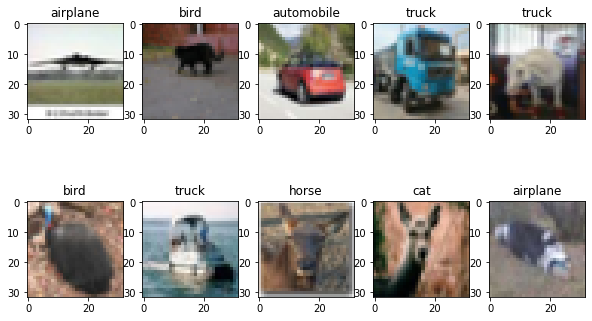

In [41]:
plt.figure(figsize=(10, 6))
for idx,i in enumerate(range(100,110)):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,X_test.shape[0])
    predicted_class = np.argmax(np.squeeze(model.predict(np.expand_dims(X_test[rand_ind,:,:,:],axis=0))))
    plt.imshow(X_test[rand_ind,:,:,:])
    plt.title(cifar_10_list[int(predicted_class)])

## Now, display all (32) trained filters of the first layer

You can explore the network parameters easily with Keras. For example ```model.layers``` is a list of the layers of the network. Each element of the network contains the information necessary for this layer. To show the content of a layer i, type :

```dir(model.layers[i])```

Display all (32) trained filters of the first layer :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32
(3, 3)
(3, 3, 32, 32)
(3, 3, 3, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

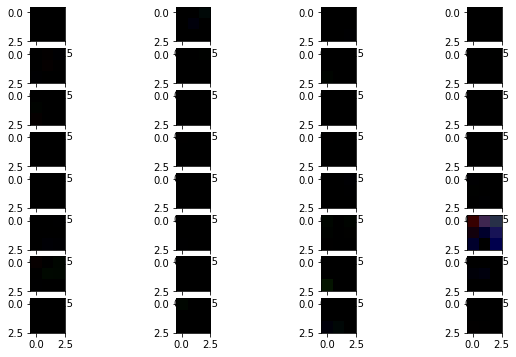

In [42]:
print(model.layers[1].filters)
print(model.layers[1].kernel_size)
print(model.layers[1].get_weights()[0].shape)
#get_weights returns and array [weights,biases]
w = model.layers[0].get_weights()[0]
print(w.shape)
plt.figure(figsize=(10, 6))
for num in range(0,32):
    plt.subplot(8, 4, num+1)
    # --- START CODE HERE
    plt.imshow(w[:,:,:,num], cmap='gray')
    # --- END CODE HERE    

# Evaluation

To evaluate the work, you should rate the code for 
- 1) Tensorflow, declaration of inputs and weights : 2 points
- 2) Tensorflow, declaration of model : 2 points
- 3) Tensorflow, training : 2 points
- 4) Keras : model : 2 points
- 5) Keras : displaying weights : 2 points

Each correct answer (correct formula/code and code runs) gives 2 points. Total over 10 points.